In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
#'''plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
#})

output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook 

$$
\displaystyle H = \hbar \sum_{i=1}^{N_{\text{atoms}}} \omega_0 \sigma_+^{(i)} \sigma_-^{(i)}
- \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}.
$$
$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|}.
$$

In [2]:
# base 2 lvl atom
psi0 = basis(2,0) # Vector |0>
psi1 = basis(2,1) # Vector |1>

In [86]:
# Set the system parameters
n_rings = 1
n_chains = 1 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

fixed_lam = 1.                # energysplitting, when ground state is set to 0
omega_0 = 2 * np.pi / fixed_lam # actually k_a
omega_d = omega_0
distance = 1 * fixed_lam

# decay and dephasing
gamma_0 = .1   # decay rate
gamma_phi = .1 # dephasing rate

alpha = 1 # coupling strength of the dipoles       Fine structure const?

# evolution
t_max = 20

In [96]:
# Setup N_atoms-Qubit operators
sx_list, sy_list, sz_list, sm_list, sp_list = [], [], [], [], []
for i in range(N_atoms):
    op_list = [qeye(2)] * N_atoms
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))
    op_list[i] = sigmam()
    sm_list.append(tensor(op_list))
    op_list[i] = sigmap()
    sp_list.append(tensor(op_list))

In [103]:
print(sx_list[0])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]


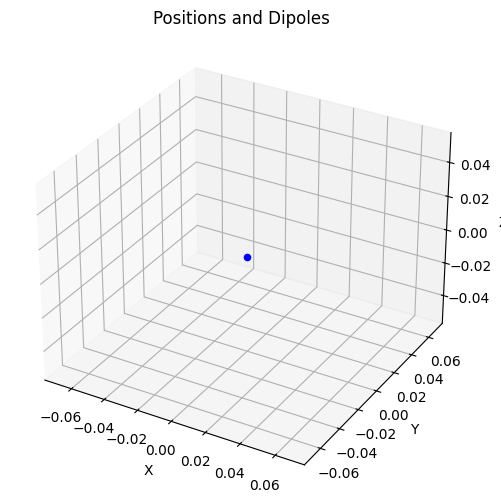

In [88]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X') 
ax.set_ylabel('Y') 
ax.set_zlabel('Z') 
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [89]:
# initial state
state_list = [psi0] * N_atoms
state_list[0] = psi1
#psiini = tensor(state_list) # Vector |100...>

'''k = np.pi / 4  # a single wavevector value

# Define the superposition state excited by a single mode with wavevector k
for i in range(2):  # Modify specific entries in the list
    # Replace a specific state in the list with psi1
    state_list[i] += np.exp(1j * k * np.linalg.norm(Pos[i])) * psi1

# Normalize the state'''
psiini = tensor(state_list).unit()
psiini

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]]

In [90]:
def Hamilton(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            base = (sp_list[a] * sm_list[b])
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))* base
            else:
                H +=  omega_0 * base # Diagonals except for |0><0|
            H += omega_d * sx_list[i]

    return H
    
H = Hamilton(distance, n_rings, n_chains)

H

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[6.28318531 6.28318531]
 [6.28318531 0.        ]]

## Single case

$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

## Collective case
$$
C_{\text{decay}} = \sum_{n=1}^{N_{\text{atoms}}} C_{\text{decay}}^{(i)} \quad
C_{\text{dephase}} = \sum_{n=1}^{\text{N_atoms}} C_{\text{dephase}}^{(i)}
$$

In [101]:
# Jump / Expect Operators

'''gamma_decay_collective = 0.1
gamma_dephase_collective = 0.1
c_op2   = [np.sqrt(gamma_decay_collective) * sum(sm_list[i] for i in range(N_atoms))] # Define the collective lowering operator (sigmam) as a sum over all spins                 c_op4 = [np.sqrt(gamma_dephase_collective) * sum(sz_list[i] for i in range(N_atoms))]'''

# Define the decay collapse and dephasing operator for each spin
c_op2 = [np.sqrt(gamma_0) * sm for sm in sm_list]                                   # EVERY ATOM  #DECAYS on its own
c_op4 = [np.sqrt(gamma_phi) * commutator(sm.dag(), sm) for sm in sm_list]           # EVEY ATOM DEPHASES ""

c_op_list = c_op2 #+ c_op4

e_op_list = [tensor([psi1 * psi1.dag() if i == j else psi0 * psi0.dag() for j in range(N_atoms)]) for i in range(N_atoms)]

<Result
  Solver: mesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 8.0108642578125e-05
    preparation time: 0.00014972686767578125
    run time: 0.7729125022888184
    solver: 'Master Equation Evolution'
    num_collapse: 1
  Time interval: [0.0, 20.0] (20000 steps)
  Number of e_ops: 1
  State not saved.
>


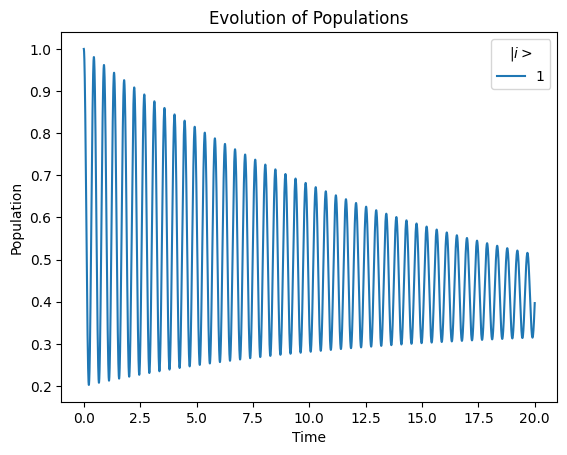

In [102]:
# evolution
times = np.linspace(0, t_max, t_max * 1000) # list of times

result = mesolve(H, psiini, times, c_ops = c_op_list, e_ops = e_op_list) #, options={"store_states": True}

print(result)
# Plot the expectation values
plt.figure()
for i in range(0, N_atoms):
    label = str(i+1) if i < 5 else None
    plt.plot(times, result.expect[i], label=label)
plt.xlabel("Time")
plt.ylabel("Population")
#Psur = sum(result.expect[i] for i in range(N_atoms))
#plt.plot(times, np.ones_like(times) - Psur, label="g")
#plt.plot(times, result.expect[0], label="g")
#plt.plot(times, Psur, label= r"$P_{\text{sur}}$")
plt.legend(title="$|i>$")

plt.title("Evolution of Populations")
plt.show()